# Yahoo Topic Classification

## Setting up Libraries and Environments

In [91]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import findspark
import pyspark
from pyspark import SparkFiles

# Data Manipulation
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# ML
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import OneVsRest, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
findspark.init()

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
'''
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()
'''

'\nspark = SparkSession.builder     .master(\'local[*]\')     .config("spark.driver.memory", "15g")     .appName(\'my-cool-app\')     .getOrCreate()\n'

## Data Import

In [6]:
schema_list = [
    StructField('Label', StringType(), False), 
    StructField('Title', StringType(), True), 
    StructField('Content', StringType(), True),
    StructField('Answer', StringType(), True),
    StructField('Set', StringType(), True)
]
schema_df = StructType(fields=schema_list)

In [7]:
# Import Data from reduced folders
df = spark.read.csv("../data/reduced", schema=schema_df)

## Data Preview
This includes some basic view of the data before processing

In [8]:
df.show(5)

+-----+--------------------+--------------------+--------------------+-----+
|Label|               Title|             Content|              Answer|  Set|
+-----+--------------------+--------------------+--------------------+-----+
|    9|I've tried talkin...|                null|~I was going to s...|Train|
|    2|Find the coordina...|Find the coordina...|"Let P be (a,b). ...|Train|
|    6|       Who will win?|Who's gonna win t...|ND go irish. USC ...|Train|
|   10|    Where do I vote?|                null|If you don't know...|Train|
|    2| help for the s.a.t?|can anyone give m...|Try some of these...|Train|
+-----+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [9]:
df.describe().show()

+-------+------------------+--------------------+--------------------------------+----------------------+------+
|summary|             Label|               Title|                         Content|                Answer|   Set|
+-------+------------------+--------------------+--------------------------------+----------------------+------+
|  count|            365124|              365124|                          201247|                358339|365124|
|   mean| 5.493070847164251|                null|                        Infinity|              Infinity|  null|
| stddev|2.8693308861059896|                null|                             NaN|                   NaN|  null|
|    min|                 1|! Does anyone els...|                               !|  ! ""Please excuse...|  Test|
|    max|                 9|﻿Speculate about ...|나보기가역겨워. 가실 때에는. ...|혼돈\nhttp://dictio...| Train|
+-------+------------------+--------------------+--------------------------------+----------------------+-----

## Data Processing

### Steps to Take
- Merge Test and Train
- Rename columns
- Change data types
- Tokenization

#### Column Concatenation

In [10]:
df = df.fillna('')

In [11]:
df = df.withColumn('Document', concat(df['Title'], df['Content'], df['Answer'])).select(['Document', 'Set', 'Label'])
df.show(5)

+--------------------+-----+-----+
|            Document|  Set|Label|
+--------------------+-----+-----+
|I've tried talkin...|Train|    9|
|Find the coordina...|Train|    2|
|Who will win?Who'...|Train|    6|
|Where do I vote?I...|Train|   10|
|help for the s.a....|Train|    2|
+--------------------+-----+-----+
only showing top 5 rows



### Processing Pipeline

Create TF-IDF column and apply PCA!

In [16]:
reg_tokenizer = RegexTokenizer(inputCol='Document', outputCol='Tokens', pattern='\\W')
stop_word_remover = StopWordsRemover(inputCol='Tokens', outputCol='StopTokens')
string_indexer = StringIndexer(inputCol='Label', outputCol='LabelString')
tf = HashingTF(inputCol='StopTokens', outputCol='CountVec', numFeatures=6000)
idf = IDF(inputCol='CountVec', outputCol='TF-IDF')

# Putting pipeline together
pipeline = Pipeline(stages=[
    reg_tokenizer,
    stop_word_remover,
    tf,
    idf,
])

# Training and fitting
pipeline = pipeline.fit(df)
df_processed = pipeline.transform(df)
df_test = df_processed.filter('Set == "Test"').select('Document', 'TF-IDF', 'Label')

In [17]:
df_processed.show(5)

+--------------------+-----+-----+--------------------+--------------------+--------------------+--------------------+
|            Document|  Set|Label|              Tokens|          StopTokens|            CountVec|              TF-IDF|
+--------------------+-----+-----+--------------------+--------------------+--------------------+--------------------+
|I've tried talkin...|Train|    9|[i, ve, tried, ta...|[ve, tried, talki...|(6000,[507,898,10...|(6000,[507,898,10...|
|Find the coordina...|Train|    2|[find, the, coord...|[find, coordinate...|(6000,[61,106,267...|(6000,[61,106,267...|
|Who will win?Who'...|Train|    6|[who, will, win, ...|[win, gonna, win,...|(6000,[25,488,499...|(6000,[25,488,499...|
|Where do I vote?I...|Train|   10|[where, do, i, vo...|[vote, know, mayb...|(6000,[1214,2818,...|(6000,[1214,2818,...|
|help for the s.a....|Train|    2|[help, for, the, ...|[help, anyone, gi...|(6000,[540,633,13...|(6000,[540,633,13...|
+--------------------+-----+-----+--------------

In [18]:
pca=PCA(k=2, inputCol="TF-IDF")
pca.setOutputCol("pca_features")

pc = pca.fit(df_test)
pc.getK()

2

In [19]:
pc.setOutputCol("output")

PCAModel: uid=PCA_34a4419746a6, k=2

In [27]:
df_pca = pc.transform(df_test).toPandas()

In [72]:
df_pca.head()

,Document,TF-IDF,Label,output
0,do you think i should see a psychiatrist?Well ...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,"[0.0033604423325592214, 3.420868022233582]"
1,any ideas on quiting smoking...?ive tried a ba...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,"[0.0004268360894230308, 3.3777595297607723]"
2,can you guess this?what goes up but never come...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,"[0.0009930311241439726, 0.15337949016142974]"
3,Do u believe in ghosts?r they 4 real?Yes. Ther...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,"[0.00664650773799073, 0.9937464475064173]"
4,what hapeend to the sport of aggrsive inline s...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,"[0.002870274048865243, 3.3271240834178366]"


In [87]:
# extract the PC values to new columns for the plot
df_pca['pc1'] = df_pca.output.apply(lambda x: x.toArray()[0])
df_pca['pc2'] = df_pca.output.apply(lambda x: x.toArray()[1])


In [89]:
df_pca.pc1.dtype

dtype('float64')

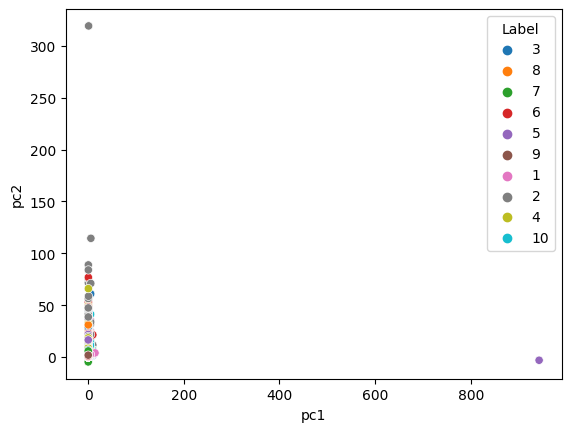

In [93]:
sns.scatterplot(x='pc1', y='pc2', hue='Label', data=df_pca)
plt.show()

In [94]:
np.quantile(df_pca.pc1, .99)

0.2508027418555475

In [95]:
np.quantile(df_pca.pc2, .99)

20.275328742410913

In [97]:
# remove outliers in PCA
def remove_outliers(df):
    q_pc1 = np.quantile(df_pca.pc1, .99)
    q_pc2 = np.quantile(df_pca.pc2, .99)
    return df.loc[(df.pc1 < q_pc1) & (df.pc2 < q_pc2), :]


In [98]:
df_pca = remove_outliers(df_pca)

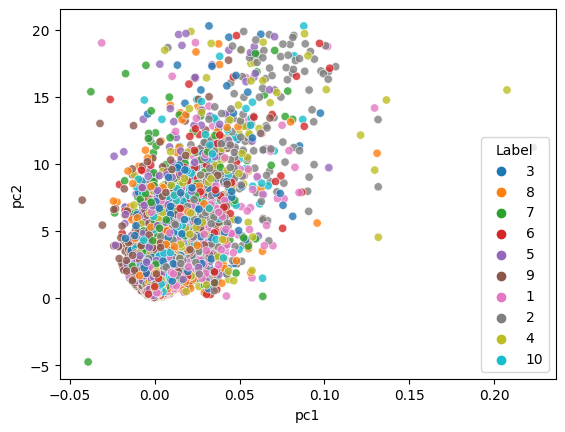

In [101]:
# plot shows that the separation is not perfect, but it is possible to identify neighborhoods where one label
# is more promininet than others.
sns.scatterplot(x='pc1', y='pc2', hue='Label', data=df_pca, alpha=0.8)
plt.show()

In [23]:
pcaPath = "../results/pca"
pca.save(pcaPath)